In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms as T
from data.transform import get_yolo_transform
from data.dataset import YOLOMaskDataset, COCO_CLASSES

from utils.convert import cells_to_boxes, xywh2tlbr
from utils.cleanup import nms_by_class
from utils.display import draw_boxes

%load_ext autoreload
%autoreload 2

In [3]:
scales = [ 13, 26, 52 ]
anchors = [
    [[0.28, 0.22], [0.38, 0.48], [0.9, 0.78]],
    [[0.07, 0.15], [0.15, 0.11], [0.14, 0.29]],
    [[0.02, 0.03], [0.04, 0.07], [0.08, 0.06]],
]

In [4]:
transform = get_yolo_transform(416, mode='train')

In [5]:
dataset = YOLOMaskDataset(csv_file="../download/COCO/test.csv",
                         img_dir="../download/COCO/images/",
                         mask_dir="../download/COCO/masks/",
                         anchors=anchors,
                         scales=scales,
                         n_classes=80,
                         transform=transform)

In [6]:
img, masks, targets = dataset[1]

In [7]:
inverse = T.ToPILImage()

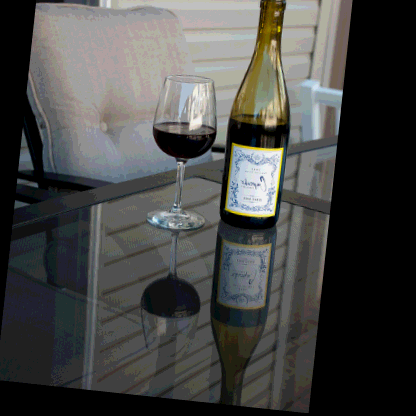

In [8]:
inverse(img)

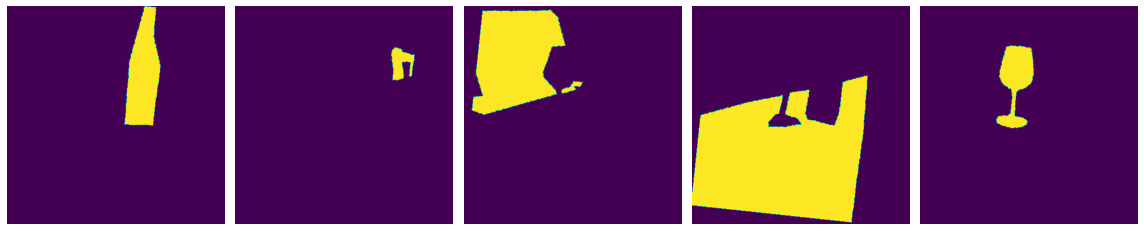

In [9]:
ncols = len(masks)

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))

for idx, mask in enumerate(masks):
    axes[idx].imshow(mask)
    axes[idx].set_axis_off()

plt.tight_layout()

In [10]:
bboxes = []
for scale, target in zip(scales, targets):
    # Convert bounding boxes to normalized format (xywh)
    cell_boxes = cells_to_boxes(target.unsqueeze(0), scale=scale)
    obj_mask = cell_boxes[..., 4] == 1.
    boxes = cell_boxes[obj_mask]
    bboxes.append(boxes)
    
# Collect sample
bboxes = torch.cat(bboxes, dim=0)

In [11]:
nms_boxes = []
# Perform NMS on each class
for c, name in enumerate(COCO_CLASSES):
    boxes = nms_by_class(bboxes, target=c, iou_threshold=0.9)
    nms_boxes.extend(boxes)
    
print(torch.tensor(np.array(nms_boxes)))

tensor([[ 5.2629e-01, -3.9712e-03,  7.2852e-01,  5.5205e-01,  1.0000e+00,
          3.9000e+01,  0.0000e+00],
        [ 3.3538e-01,  1.7182e-01,  5.3000e-01,  5.6376e-01,  1.0000e+00,
          4.0000e+01,  4.0000e+00],
        [ 7.0215e-01,  1.8346e-01,  8.2188e-01,  3.4539e-01,  1.0000e+00,
          5.6000e+01,  1.0000e+00],
        [ 3.0801e-02, -3.4501e-03,  5.7497e-01,  5.4191e-01,  1.0000e+00,
          5.6000e+01,  2.0000e+00],
        [-4.5481e-03,  2.3503e-01,  8.0743e-01,  9.9094e-01,  1.0000e+00,
          6.0000e+01,  3.0000e+00]], dtype=torch.float64)


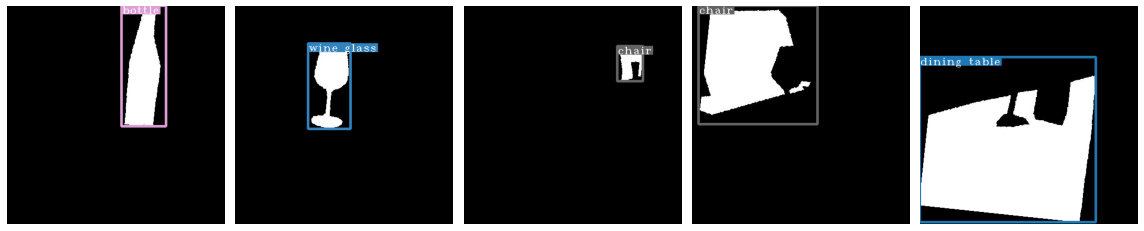

In [12]:
ncols = len(masks)

fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
img_width, img_height = masks[0].shape[1], masks[0].shape[0]

bboxes = torch.tensor(nms_boxes)
bboxes[..., 0] *= img_width
bboxes[..., 1] *= img_height
bboxes[..., 2] *= img_width
bboxes[..., 3] *= img_height

for idx, box in enumerate(bboxes):
    mask_id = int(box[-1])
    mask = masks[mask_id]
    canvas = np.uint8(np.stack((mask,)*3, axis=-1)*255)
    draw_boxes(canvas, box.unsqueeze(0).tolist(), COCO_CLASSES)
    axes[idx].imshow(canvas)
    axes[idx].set_axis_off()

plt.tight_layout()